
## TP 3 and 4
These lab sessions are conducted as part of the NLP course at Mines

### Objective:
- introduce a tokenizer
- build a Transformer
- explore padding and attention mechanisms for the Transformer
- train a small Transformer on the "civil code" dataset, on CPU
- train a larger Transformer on the same dataset, on GPU
- Perform evaluation and visualize loss curves
- Generate new words for the civil code!

In [7]:

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset, DatasetDict
import pandas as pd



## Data Preparation
Building a dataset from words in the civil code and labor code


In [8]:
words = open('data/codes_mots/civil_mots.txt', 'r').read().splitlines()
nb_words = len(words)
print("nb_words code civil =", nb_words)

words2 = open('data/codes_mots/code_travail_mots.txt', 'r').read().splitlines()
print(f'nb_words code travail = {len(words2)}')

df = pd.DataFrame({'text': words + words2, 'source' : ['civil']*len(words) + ['travail']*len(words2)})


nb_words code civil = 7223
nb_words code travail = 12105


### Dataset Tokenization
We will download a simple tokenizer from Huggingface and experiment with it

In [9]:

from transformers import PreTrainedTokenizer, LlamaTokenizer

# Load the tokenizer
tokenizer_name = "keeeeenw/MicroLlama"
tokenizer = LlamaTokenizer.from_pretrained(tokenizer_name)


print(type(tokenizer))  
# we're working with a LlamaTokenizer, which is specifically designed for LLama-based models.

# some operations
# text to tokens
tokens = tokenizer.encode("tanguy")
print(tokens)  

# tokens back to text
text = tokenizer.decode([1, 260, 2375])
print(text)  # This will output the original text

# Get vocabulary size
vocab_size = tokenizer.get_vocab().__len__()
print(f"Vocabulary size: {vocab_size}")

# Look up specific token IDs
token_id = tokenizer.get_vocab()["angu"]
print(f"Token ID for 'angu': {token_id}")


<class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>
[1, 260, 2375, 29891]
<s>tangu
Vocabulary size: 32000
Token ID for 'angu': 2375



## How Tokenization Works
### The Dictionary Analogy
Think of a tokenizer as a bilingual dictionary where:
- The "words" can be complete words, parts of words, or even characters
- Each "definition" is a unique number (token ID)
- The dictionary is fixed - once trained, the mappings don't change




In [10]:

# Testing the tokenizer
examples = [
    "Hello, world!",
    "Machine learning",
    "Neural networks",
    "GPT-3"
]

for text in examples:
    tokens = tokenizer.encode(text)
    decoded = tokenizer.decode(tokens)
    print(f"Original: {text}")
    print(f"Tokens: {tokens}")
    print(f"Decoded: {decoded}\n")



Original: Hello, world!
Tokens: [1, 15043, 29892, 3186, 29991]
Decoded: <s>Hello, world!

Original: Machine learning
Tokens: [1, 6189, 6509]
Decoded: <s>Machine learning

Original: Neural networks
Tokens: [1, 2448, 3631, 14379]
Decoded: <s>Neural networks

Original: GPT-3
Tokens: [1, 402, 7982, 29899, 29941]
Decoded: <s>GPT-3



## Tokenization of dataset
There are two options that i see for tokenizing the words in the dataset 
- Option 1: tokenization without the EOS token 
- Option 2: tokenization with the EOS token

### Option 1: No EOS token

In [11]:

tokenizer.pad_token = tokenizer.eos_token
def tokenize(examples):
    return tokenizer(examples['text'], padding="longest", truncation=True, max_length=512)

word = words[0]
tokenized = tokenizer(word,  padding='longest', truncation=True, max_length=512)
print(tokenized)

{'input_ids': [1, 263], 'attention_mask': [1, 1]}


In [13]:

df = df.sample(frac=1).reset_index(drop=True)  # Corrected shuffle method
df["is_train"] = df.index % 5 != 0
# dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())

train_df = df[df["is_train"]]  # 80% for training
valid_df = df[~df["is_train"]]  # 20% for validation

# Convert DataFrames to Hugging Face Dataset objects
train_dataset = Dataset(pa.Table.from_pandas(train_df))
valid_dataset = Dataset(pa.Table.from_pandas(valid_df))

# Combine into a DatasetDict
hg_dataset = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset
})
hg_dataset_tokenized = hg_dataset.map(tokenize)


Map:   0%|          | 0/15462 [00:00<?, ? examples/s]

Map:   0%|          | 0/3866 [00:00<?, ? examples/s]

### Padding Experiments

how does the input size of the sequence affect the training ? 


can any model take in any max sequence length ?


In [ ]:

from transformers import AutoModelForCausalLM
model_name = tokenizer_name
print(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
#%% 
inputid = hg_dataset_tokenized["train"][10]['input_ids']
model.model.layers = model.model.layers[:2]
input_ids = torch.tensor([inputid])
# labels = input_ids.clone()
input_ids_with_padding = torch.tensor([inputid + [tokenizer.pad_token_id]*5 + inputid])
labels = input_ids_with_padding.clone()
attention_mask = torch.tensor([[1]*len(inputid) + [0]*5 + [1]*len(inputid)])
#%%

def graph_attention_mask(attention_matrix:torch.Tensor):
    import numpy as np
    import matplotlib.pyplot as plt
    mymask = attention_matrix.numpy()[0,0].copy()
    mymask[mymask < -1e10] = 1
    mymask = 1-mymask
    plt.title("Input: <s>inspecteurs<PAD><PAD><PAD>inspecteurs")
    plt.imshow(mymask)
    plt.savefig("attention_mask2.png")

keeeeenw/MicroLlama


## Attention Masks

Some Attention Masks are graphed below.

### No Padding

Here is the attention mask in the case of a non padded, causal language modeling task, such as text generation. 
Notice that a given token only attends to the tokens that precede it. 
Token number 2 only attends to tokens 1 and 2. 


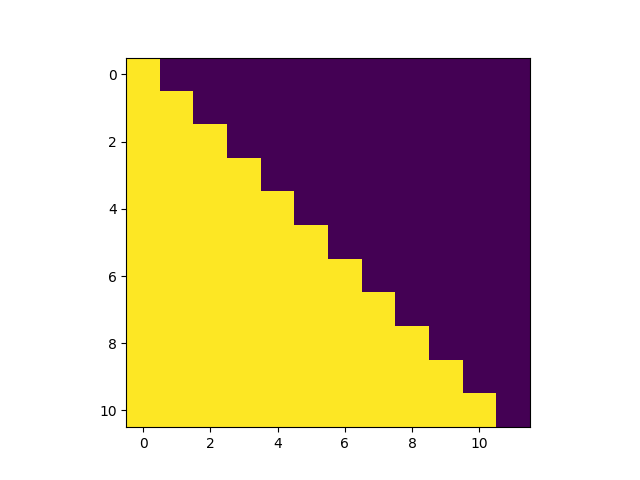

### End Padding

Here is the attention mask in the case of padding at the end of the input. This is an important case, as it appears whenever samples are batched together using padding to match the length of the longest sequence in the graph. Notice that we this code does not prevent the padding tokens from attending non-padded token positions. The only rule applied is that no token ever attends to a padded token position.
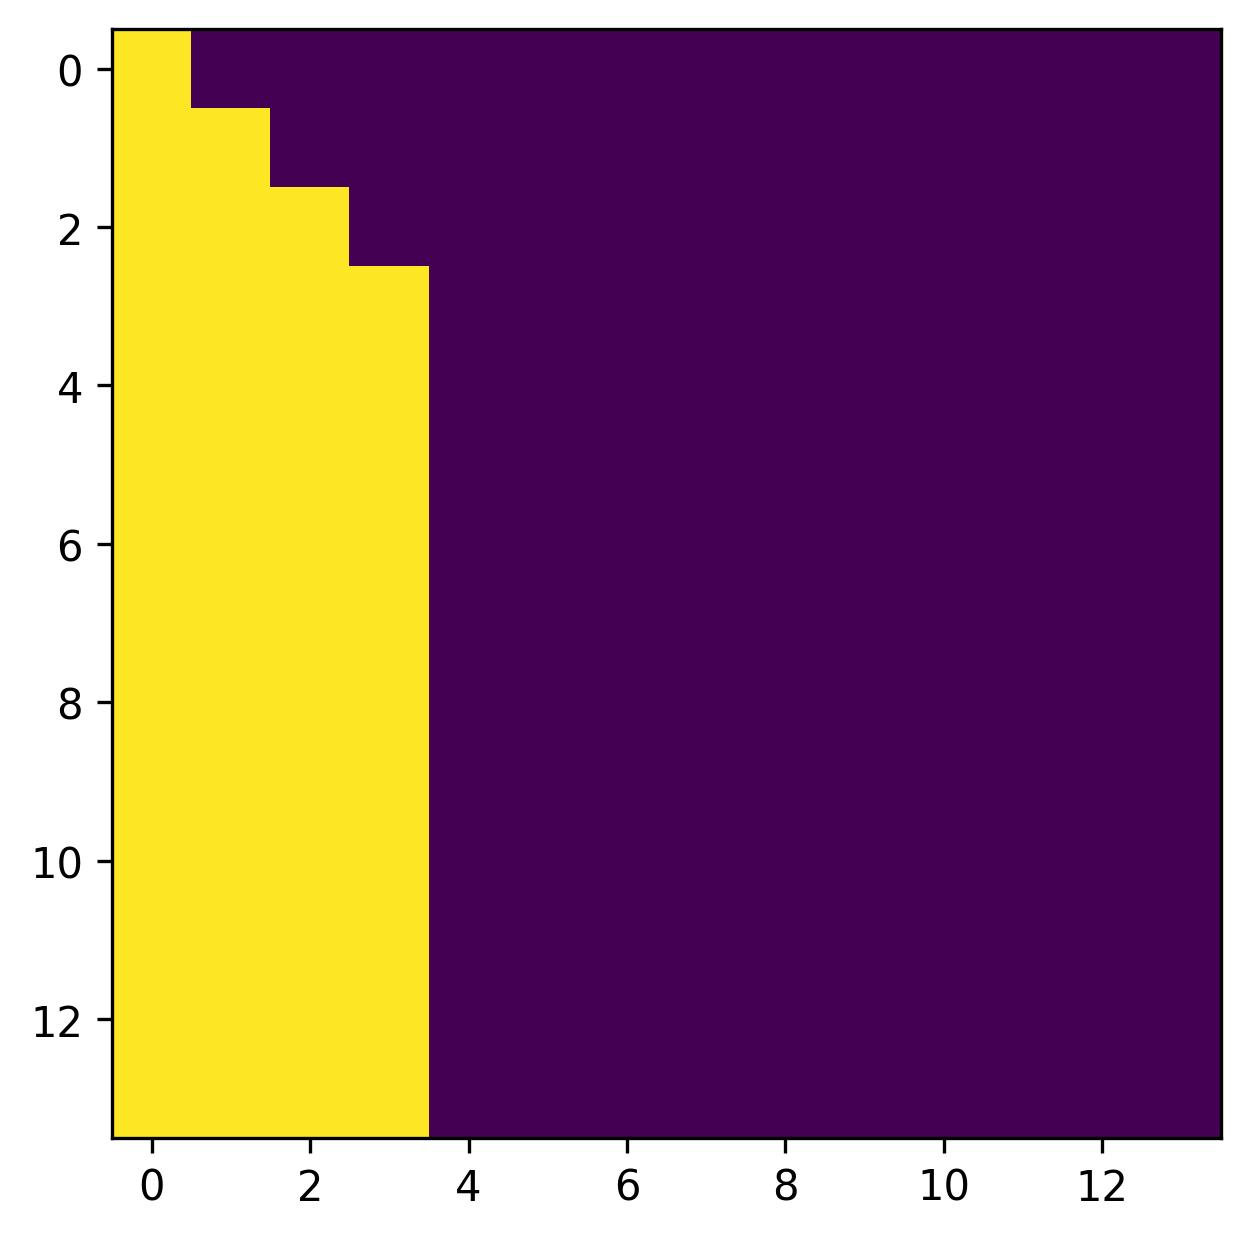

### Middle Padding

Here is the attention mask in the case of padding in the middle of the input sequence. 
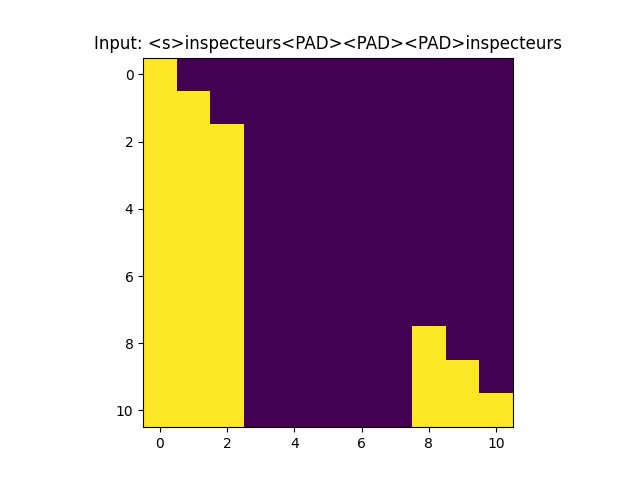


Here are the same matrices, but showing the attention weights, after summing the attention matrix with the attention mask, and applying the softmax function ! We give two examples here, corresponding to the attention weights of the first two attention layers of an untrained model. 
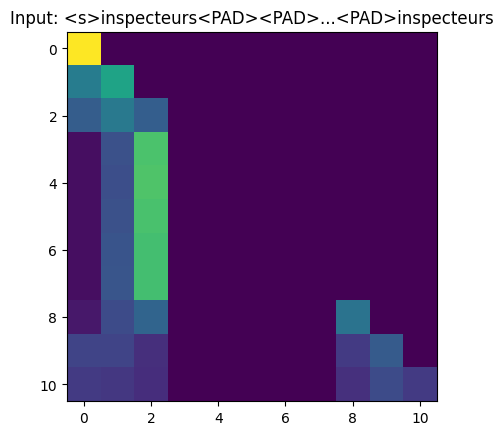

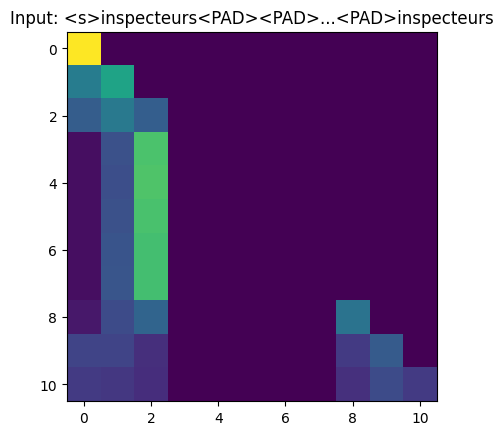

## Training a GPT model 
Lets train a Llama model for generating more words, based on the French codes.

In [16]:
import pyarrow as pa
from datasets import DatasetDict
chars = sorted(list(set(''.join(words))))
print(chars)
nb_chars = len(chars) + 1  # On ajoute 1 pour EOS
print("nb_chars =", nb_chars)



from transformers import PreTrainedTokenizer, LlamaTokenizer
tokenizer_name = "keeeeenw/MicroLlama"
tokenizer : LlamaTokenizer= LlamaTokenizer.from_pretrained(tokenizer_name)




df = df.sample(frac=1).reset_index(drop=True)  # Corrected shuffle method
df["is_train"] = df.index % 5 != 0
# dataset = ds.dataset(pa.Table.from_pandas(df).to_batches())
# df = df.sample(frac=0.1) # to remove 
train_df = df[df["is_train"]]  # 80% for training
valid_df = df[~df["is_train"]]  # 20% for validation

# Convert DataFrames to Hugging Face Dataset objects
train_dataset = Dataset(pa.Table.from_pandas(train_df))
valid_dataset = Dataset(pa.Table.from_pandas(valid_df))

# Combine into a DatasetDict
hg_dataset = DatasetDict({
    "train": train_dataset,
    "validation": valid_dataset
})


["'", '-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'à', 'â', 'ç', 'è', 'é', 'ê', 'ë', 'î', 'ï', 'ô', 'ù', 'û', 'œ']
nb_chars = 41


In [ ]:
from dataclasses import dataclass
@dataclass
class DataCollatorCustom:
    tokenizer: PreTrainedTokenizerBase
    return_tensors: str = "pt"
    def __call__(self, features:list[dict]):
        input_ids = []
        attention_masks = []
        labels = []
        for sample in features:
            input_ids.append(sample["input_ids"])
            attention_masks.append(sample["attention_mask"])
            if "labels" in sample:
                labels.append(sample["labels"])
            else:
                labels.append(sample["input_ids"].copy())
        longest_input = max([len(input_id) for input_id in input_ids])
        # print(f'longest_input = {longest_input}')
        input_ids = [input_id + [self.tokenizer.pad_token_id]*(longest_input - len(input_id)) for input_id in input_ids]
        attention_masks = [attention_mask + [0]*(longest_input - len(attention_mask)) for attention_mask in attention_masks]
        input_ids_tensor = torch.tensor(input_ids)
        labels_tensor = torch.tensor(input_ids)
        return {"input_ids": input_ids_tensor, 
                "attention_mask": torch.tensor(attention_masks),
                "labels": labels_tensor}
    

def generate_text(model_to_use, prompt, max_length=50):
    # Tokenize the input prompt
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    
    # Generate
    outputs = model_to_use.generate(
        inputs["input_ids"],
        max_length=max_length,
        num_return_sequences=3,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.pad_token_id,
        bos_token_id=tokenizer.bos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )
    
    # Decode and return the generated text
    return [tokenizer.decode(output, skip_special_tokens=True) for output in outputs]


def tokenize_v2(examples, max_length=512):
    # Add EOS token by setting add_special_tokens=True
    outputs = tokenizer(
        examples['text'],
        padding="longest",
        truncation=True,
        max_length=max_length,
        add_special_tokens=True  # This ensures special tokens like EOS are added
    )
    
    # If you specifically want to force EOS at the end of each sequence:
    if outputs['input_ids'][-1] != tokenizer.eos_token_id:
        # Only add if there's room and it's not already there
        if len(outputs['input_ids']) < max_length:
            outputs['input_ids'].append(tokenizer.eos_token_id)
            outputs['attention_mask'].append(1)
        else:
            # Truncate and replace the last token with EOS
            outputs['input_ids'][-1] = tokenizer.eos_token_id
    return outputs






In [ ]:
tokenizer.pad_token = tokenizer.eos_token
hg_dataset_tokenized = hg_dataset.map(tokenize_v2)
data_collator = DataCollatorCustom(tokenizer)


In [ ]:
NUM_GPUS = 2 
train_size = len(hg_dataset_tokenized['train'])
per_device_train_batch_size = 64
steps_training = int(train_size / (NUM_GPUS*per_device_train_batch_size))
logging_steps = int(steps_training/ 20)
eval_steps =int( logging_steps *8)
print(steps_training, eval_steps, logging_steps)

In [ ]:
from transformers import TrainingArguments, Trainer
import wandb 
from transformers import LlamaConfig, LlamaForCausalLM


training_args = TrainingArguments(
    output_dir="/kaggle/working/results",
    overwrite_output_dir=True,
    num_train_epochs=10,
    per_device_train_batch_size=per_device_train_batch_size,
    save_steps=eval_steps * 10,
    save_total_limit=1,
    use_cpu=False,
    # Add wandb logging parameters
    report_to="wandb",
    logging_dir="/kaggle/working/logs",
    logging_strategy = "steps",
    logging_steps=logging_steps,  # How often to log metrics
    evaluation_strategy="steps",  # Log evaluation metrics
    eval_steps=eval_steps,  # How often to run evaluation
    load_best_model_at_end=True,
    metric_for_best_model="loss",
    greater_is_better=False,
)




from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("WANDB")
wandb.login(key=secret_value_0)
wandb.finish()
wandb.init(
    project="nlp_project_lesmines",
    config={
        "learning_rate": 0.2,
        "architecture": "LlamaModel_small_v2",
        "dataset": "civil_mots + code_travail_mots",
    }
)
small_config = {
    "num_hidden_layers": 3,
    "hidden_size": 64,
    "intermediate_size": 256,
    "num_attention_heads": 4,
    "num_key_value_heads": 1,
    # Required additional parameters
    "max_position_embeddings": 512,  # Maximum sequence length
    "vocab_size": 32000,            # Size of the tokenizer vocabulary
    "rms_norm_eps": 1e-6,          # Layer normalization epsilon
    "bos_token_id": 1,             # Beginning of sequence token
    "eos_token_id": 2,             # End of sequence token
    "pad_token_id": 2,             # Padding token
}
smallconfig = LlamaConfig(**small_config)
smallmodel = LlamaForCausalLM(smallconfig)


trainer_v2 = Trainer(
    model=smallmodel,
    args=training_args,
    train_dataset=hg_dataset_tokenized["train"],
    eval_dataset = hg_dataset_tokenized["validation"],
    data_collator=data_collator,
)

trainer_v2.train()

## Results 

We have done a number of training runs
Here is the final and best run:
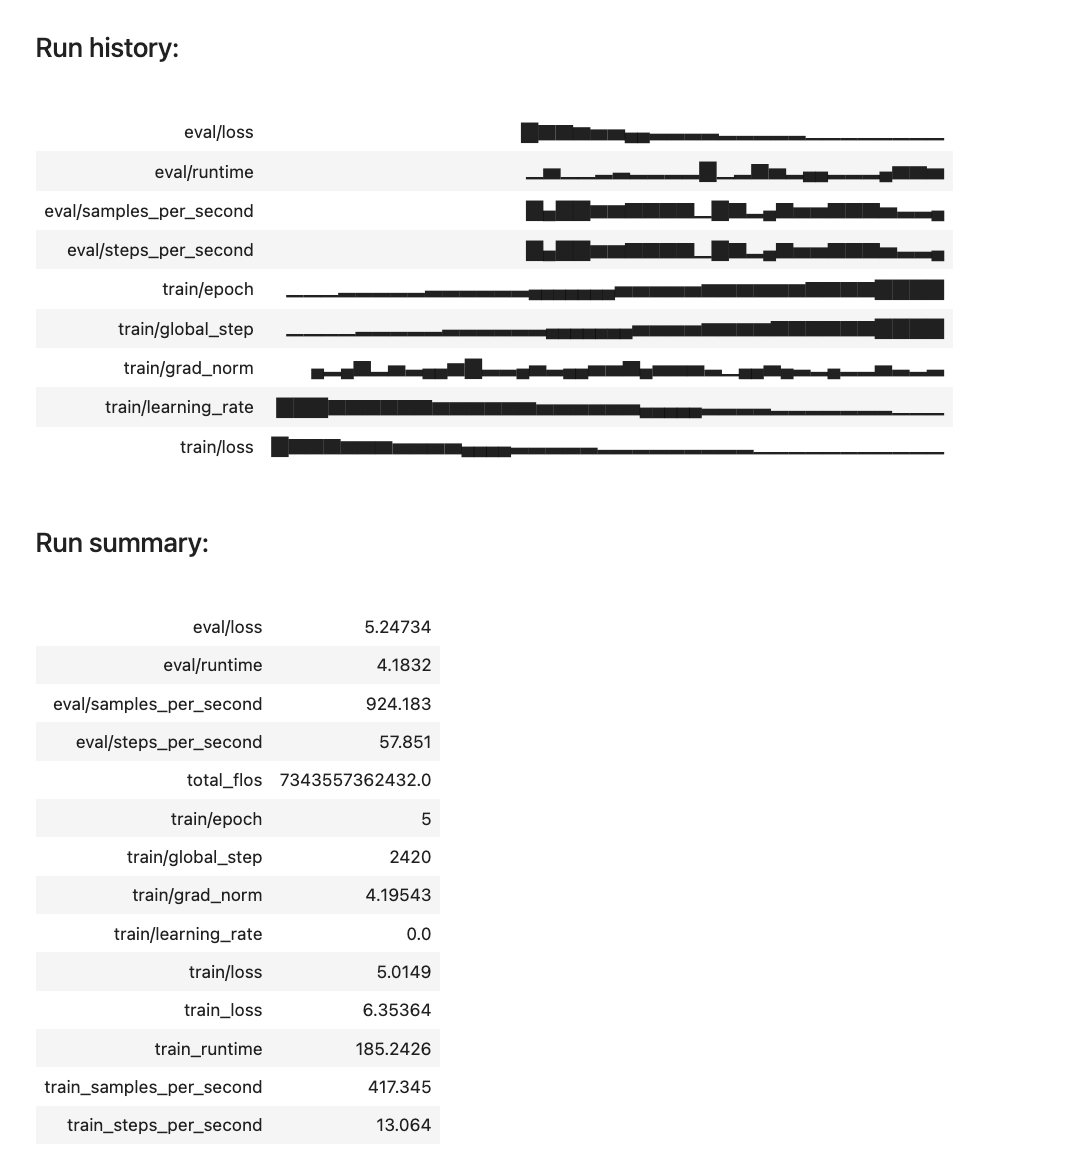
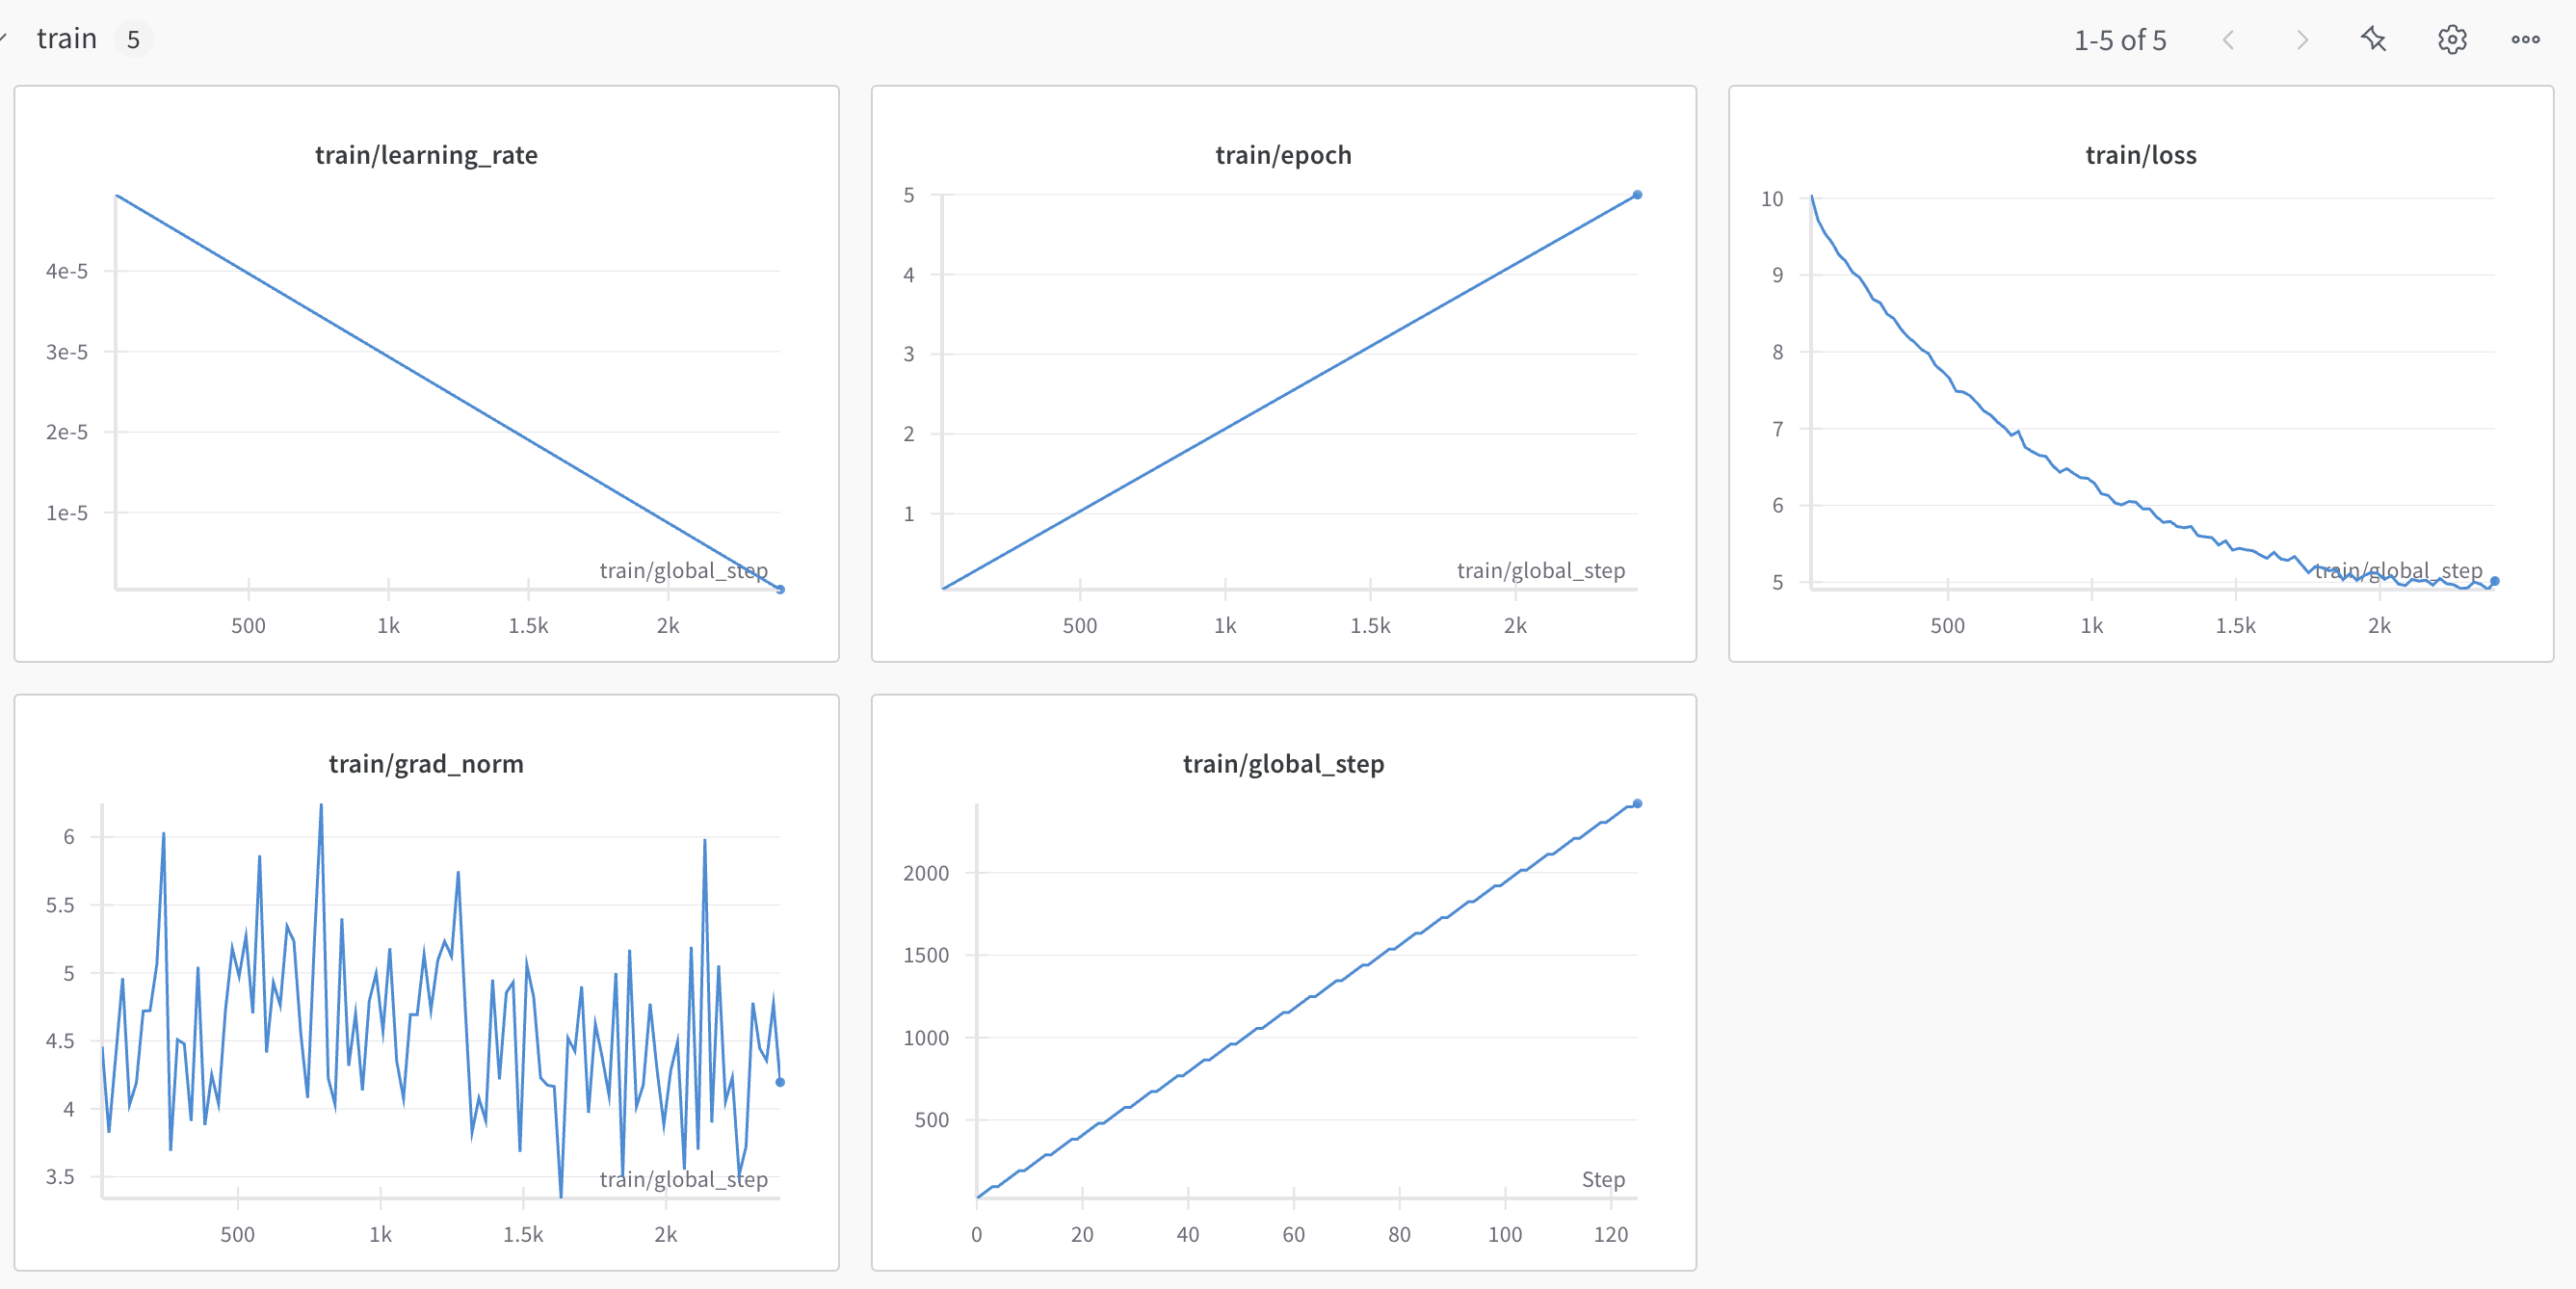

Notice that the cross entropy loss follows a downward curve down from 10 to 5. 



## Word Generation 


In [ ]:


max_length = 50
temperature = 0.7
prompt = "Bonjour "
generated_tokens = ""
smallmodel = smallmodel.cpu()
input_ids = tokenizer(prompt, return_tensors="pt")['input_ids']
generated_tokens = input_ids[0].tolist()

for _ in range(max_length):
    outputs = smallmodel(input_ids=torch.tensor([generated_tokens], dtype=torch.long))
    next_token_logits = outputs.logits[:, -1, :] / temperature
    
    # Apply softmax to get probabilities
    probs = torch.nn.functional.softmax(next_token_logits, dim=-1)
    
    # Sample from the distribution
    next_token = torch.multinomial(probs[0], num_samples=1).item()
    
    generated_tokens.append(next_token)
    
    if next_token == tokenizer.eos_token_id:
        print("EOS token found, stopping generation")
        break
generated_tokens = [int(token) for i, token in enumerate(generated_tokens) if i >= len(input_ids)]
tokenizer.decode(generated_tokens)  



With the run "vivid-22" (the best run), here are some of the word generations 


```markdown
'Bonjour earhibernateਰ Loop proxim Parlament внеvalue notifications slow OpeniaTRUEזварhor urlModuleFirstingsområ enginesverio РозAUTي dictionaryyer…ac agr verb instit reasonable систеeurs Militär次слуéri utiliz§ordinary ant generaleitte Ladска worthgré'
```

### Problems and next steps 

I notice that in the generation above, the model never uses the eos token, which means that it cannot designate the end of a word. 

In addition, the model does not seem to have learned much of the French word syntax...

### Debugging the eos token not being generated 
I believe the loss is not taking into account the EOS token. 

We can check that the padding tokens are set to -100 in the loss, but the EOS token is not.
